**Rationale** Texts have become one of the most ubiquitous forms of marketing data in the digital economy. Perhaps nowhere is this more prevalent than in the online reviews domain. In our notes, we examined how natural language processing (NLP) techniques can be applied to Yelp restaurant reviews. On this homework assignment, you will apply the same tools to mine TripAdvisor hotel reviews. This dataset includes all TripAdvisor reviews written in 2015 (through part of 2016) for high review volume Vegas resorts and was collected as part of a large web crawl of over 50 Million online reviews at over 428k worldwide hotels by your professor and his colleague, Dr. Alex Chaudhry in 2016. 

* [Dataset](https://drive.google.com/drive/folders/16eyzTI32aKsKiLf9oPMzL3v2U30afd01?usp=sharing)

You will only need:
* vegas_2015_reviews.csv contains the reviews 
* vegas_info.csv contains a list of venues in Vegas

Get started early on this assignment, some components **take a while to run**. 

This assignment will be slightly different. Please follow all prompts.

1. This is a walkthrough tutorial, mostly. I have provided you with most of the necessary code. Your job is to run it, read it, understand how it relates to NLP concepts.
1. There are many questions throughout. You will primarily be graded on these.
1. There are a few places where I ask you to write some code. Pay attention to every cell, make sure you don't skip a cell that you must fill in on accident. Hopefully, this foces you to read through the code thoroughly.

# Imports and helper functions (execute these cells first)

In [9]:
from google.colab import drive
drive.mount('drive/')

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from textblob import TextBlob 


In [11]:
# imports

import nltk
nltk.download('stopwords') # download stopwords from NLTK servers
from nltk.corpus import stopwords # import them
sw = stopwords.words('english')


import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, time # standard imports
from itertools import chain

# for sentiment analysis
from textblob import TextBlob 

# for doing text processing and LDA
import spacy
from gensim.models.ldamulticore import LdaMulticore # this is the multi-core version
from gensim import corpora # import the corpora module
from gensim.models import Phrases
from gensim.models import tfidfmodel
from gensim.models.word2vec import LineSentence
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:

# Helper Functions
def line_doc(filename, encode = 'utf-8'):
    """
    generator function to read in reviews from the file
    and un-escape the original line breaks in the text
    """
    with open(filename, 'r', encoding = encode) as f:
        for txt in f:
            # yield returns next line
            yield txt.replace('\\n', '\n')
            # and get rid of any line breaks

# parsing to be done per sentence
def lemmatize(s, exclude):
    return [w.lemma_.lower() for w in s if (w.lemma_ not in exclude)&(~w.is_punct)]


# next will be a function that will pass a filename to the line_doc function
# and generate the parsed versions of ***EVERY SENTENCE***
# this function streams a file at filename and yields one parsed sentence at a time
def lemmatize_sentence_corpus(filename,nlp, batch_size, n_threads, sw=[], exclusions=[], encode = 'utf-8'):
    nlp.disable_pipes(["ner"]) # disable ner and tagger makes it a little faster
    # batch_size is the number of documents to parse in memory at a time
    # n_threads it the number of parallel (simultaneous processes to run)
    # n_threads is limited by the number of virtual cpu's on the system
    # the default free Colab system has only 2 virtual cores
    # most modern computers have at least 4
    exclude = set(sw + exclusions)
    for parsed_txt in nlp.pipe(line_doc(filename, encode = encode),batch_size=batch_size, n_threads=n_threads):
            for sent in parsed_txt.sents:
                yield ' '.join(lemmatize(sent, exclude))


def write_parsed_sentence_corpus(readfile, writefile, nlp, batch_size, n_threads, sw=[], exclusions =[], encode = 'utf-8'):
    streamingfile = lemmatize_sentence_corpus(readfile,nlp, batch_size, n_threads, sw=sw, exclusions=exclusions, encode = encode)
    with open(writefile, 'w', encoding = encode) as f:
        for sentence in streamingfile:
            if len(sentence)>0: # write sentence if includes non stopwords
                f.write(sentence+'\n')
    print('Success')


def phrase_detection(parsedfile, folderpath, passes = 2, returnmodels = True,threshold=10., encode = 'utf-8'):
    """
    parsedfile is the file location and name of the parsed sentence file
    folderpath is where the models and phrase detected texts need to be stored

    This function does phrase modeling. User specifies the number of passes.
    Each additional pass detects longer phrases. The maximum detectable phrase length for
    each pass, n, is 2^n.
    Returns the list of models by default. Also saves models and intermediary
    phrased sentences for each pass.
    """
    ngram = list()
    for it in range(passes):
        gen = LineSentence(parsedfile)
        gram=Phrases(gen, threshold = threshold)
        ngram.append(gram)
        modelpath = folderpath+'phrase_model_{}.phrasemodel'.format(it+1)
        textpath = folderpath+'sent_gram_{}.txt'.format(it+1)
        parsedfile = textpath
        gram.save(modelpath)
        # Write sentence n-gram
        with open(textpath, 'w', encoding=encode) as f:
            for sent in gen:
                new_sent = ' '.join(gram[sent])
                f.write(new_sent + '\n')

    if returnmodels == True:
        return ngram


def phrase_prediction(rawfilepath, outpath,nlp, grams, sw =[], exclusions = [], batch_size = 500, n_threads = 2, encode = 'utf-8'):
    """
    rawfilepath is where the raw reviews (where 1 line = 1 review) are saved 
    outpath is where to save the resulting parsed and phrase modeled reviews
    nlp is the spacy parser object
    grams is a list of phrasemodels
    sw is a list of stopwords
    exclusions are additional words to exclude

    """
    with open(outpath, 'w', encoding = encode) as f:
        
        nlp.disable_pipes(["ner"]) # disable ner and tagger makes it a little faster
        exclude = set(sw + exclusions)
        
        for parsed_txt in nlp.pipe(line_doc(rawfilepath, encode = encode),batch_size=batch_size, n_threads=n_threads):
            doc = list()
            for sent in parsed_txt.sents:
                parsed = lemmatize(sent, exclude)
                for gram in grams: # loop through phrase models
                    parsed = gram[parsed] # apply phrase model transformation to sentence
                doc.append(' '.join(parsed).strip()) # append resulting phrase modeled sentence to list "doc"
            # write the transformed review as a single line in the new file
            txt_gram = ' '.join(doc).strip() # join all sentences in doc together as txt_gram
            f.write(txt_gram + '\n') # write the entire phrase modeled and parsed doc as one line in file

# Put together the dataset (1 point)

In [13]:
fpath = 'drive/MyDrive/MKTG3509/Data Sets/' # change this filepath
os.listdir(fpath)

['Avocado.xlsx',
 'quebec_biz.csv',
 'quebec_yelp_reviews.csv',
 'goodDataSet.csv',
 'renttherunway_final_data.json',
 'telecom_churn.csv',
 'starbucks_promos.csv',
 'facebook_ads.csv',
 'temple_traffic.csv',
 'avocado.csv',
 'online_invoices.csv',
 'vegas2015reviews.csv',
 'vegas_vinfo.csv']

In [14]:
# read in the vegas_vinfo file (vegas venue info)
df_biz = pd.read_csv(fpath + 'vegas_vinfo.csv', index_col = 0)
df_biz.head()

,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat,gd
0,"[10, 33]",60.0,NaN,"[-115.06332, 36.1191]",{},Hotel_Review,{'Services': 'Free Parking Banquet Room Self-S...,"{'Number of rooms:': '398 ', 'Address:': '3890...",Las Vegas RV Resort,4.0,g45963-d3600552
1,"[209, 267]",63.0,NaN,"[-115.08308, 36.127922]",{},Hotel_Review,{'Things to do': 'Pool Fitness Center with Gym...,"{'Address:': '4240 Boulder Hwy, Las Vegas, NV ...",Crossland Economy Studios - Las Vegas - Boulde...,2.5,g45963-d97850
2,"[197, 267]",100.0,NaN,"[-115.19604, 36.20166]",{},Hotel_Review,"{'Room types': 'Non-Smoking Rooms ', 'Services...","{'Address:': '2400 N Rancho Dr, Las Vegas, NV ...",Fiesta Rancho Hotel and Casino,2.5,g45963-d121329
3,"[228, 267]",27.0,NaN,"[-115.19868, 36.201473]",{},Hotel_Review,"{'Things to do': 'Pool ', 'About the property'...",{'Also Known As:': 'Budget Suites Of America N...,Budget Suites of America North Rancho Drive,1.5,g45963-d91750
4,"[1, 33]",271.0,NaN,"[-115.1785, 36.040703]",{},Hotel_Review,{'Services': 'Self-Serve Laundry Free Parking ...,{'Also Known As:': 'Oasis Las Vegas Rv Hotel L...,Oasis Las Vegas RV Resort,4.5,g45963-d226809


Variable definitions
1. ranking: list [hotel rank, total hotels in neighborhood]
1. rating_vol: total ratings
1. rdetails: ignore, none of hotels have this field (only restaurants do)
1. lnglat: [longitude,latitude] of hotel
1. rsubrating: ignore, only restaurants have this
1. amenities: a dictionary of amenities categories mapped to amenities list
1. details: a dictionary of hotel information fields mapped to hotel data (like addrese, phone, website, etc.)
1. v_name: the official name of the hotel 
1. rating_cat: The summary star rating (in half star increments) displayed to the user. 
1. gd: The unique hotel identifier.

In [15]:
# return the shape of df_biz:
df_biz.shape

(237, 11)

In [16]:
# preview df_biz
df_biz.head()

,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat,gd
0,"[10, 33]",60.0,NaN,"[-115.06332, 36.1191]",{},Hotel_Review,{'Services': 'Free Parking Banquet Room Self-S...,"{'Number of rooms:': '398 ', 'Address:': '3890...",Las Vegas RV Resort,4.0,g45963-d3600552
1,"[209, 267]",63.0,NaN,"[-115.08308, 36.127922]",{},Hotel_Review,{'Things to do': 'Pool Fitness Center with Gym...,"{'Address:': '4240 Boulder Hwy, Las Vegas, NV ...",Crossland Economy Studios - Las Vegas - Boulde...,2.5,g45963-d97850
2,"[197, 267]",100.0,NaN,"[-115.19604, 36.20166]",{},Hotel_Review,"{'Room types': 'Non-Smoking Rooms ', 'Services...","{'Address:': '2400 N Rancho Dr, Las Vegas, NV ...",Fiesta Rancho Hotel and Casino,2.5,g45963-d121329
3,"[228, 267]",27.0,NaN,"[-115.19868, 36.201473]",{},Hotel_Review,"{'Things to do': 'Pool ', 'About the property'...",{'Also Known As:': 'Budget Suites Of America N...,Budget Suites of America North Rancho Drive,1.5,g45963-d91750
4,"[1, 33]",271.0,NaN,"[-115.1785, 36.040703]",{},Hotel_Review,{'Services': 'Self-Serve Laundry Free Parking ...,{'Also Known As:': 'Oasis Las Vegas Rv Hotel L...,Oasis Las Vegas RV Resort,4.5,g45963-d226809


**Answer these**
1. What does 1 row of `df_biz` represent (e.g., reviewers, hotels, cities, etc.)? **It represents the hotel being reviewed** \
1. How many hotels are in this dataset? **237 Hotels**


In [17]:
# read in the vegas2015reviews.csv file
df = pd.read_csv(fpath + 'vegas2015reviews.csv', index_col = 0)

In [18]:
df.head()

,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username
15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby
15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H
15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser
15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates
15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A


Variable definitions

1. gd: hotel identifier
1. helpful_num: number of helpful votes
1. location: location of the reviewer
1. mgrRspnDummy: whether a manager responded to the review
1. mgr_res_date: when the manager responded
1. mrtext: reply of the manager
1. ratingDate: when the review was written
1. review_id: unique identifer for each review
1. reviewrating: rationg (1-5) given by the reviewer
1. reviewtext: the text of the review
1. reviewtitle: title of the review
1. stay_month: 1-12 month of the stay
1. stay_year: year of the stay
1. travel_category: stated purpose of the stay
1. username: user's tripadvisor screen name

In [19]:
# convert ratingDate column to pandas datetime format using the pd.to_datetime function
df.ratingDate = pd.to_datetime(df.ratingDate)

In [20]:
df.ratingDate# check the ratingDate column to ensure the data are now pandas timestamps


15044    2015-07-01
15045    2015-07-01
15046    2015-06-30
15047    2015-06-13
15058    2015-06-13
            ...    
904218   2015-03-15
904229   2015-03-15
904240   2015-03-15
904251   2015-03-15
904262   2015-03-14
Name: ratingDate, Length: 46644, dtype: datetime64[ns]

In [21]:
# get the shape of the dataframe df
df.shape

(46644, 15)

In [22]:
# preview df
df.head()

,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username
15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby
15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H
15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser
15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates
15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A


In [23]:
# look at the columns of df (e.g. df.columns)
df.columns

Index(['gd', 'helpful_num', 'location', 'mgrRspnDummy', 'mgr_res_date',
       'mrtext', 'ratingDate', 'review_id', 'reviewrating', 'reviewtext',
       'reviewtitle', 'stay_month', 'stay_year', 'travel_category',
       'username'],
      dtype='object')

In [24]:
# what are the columns that belong to both df and df_biz?
set(df.columns).intersection(set(df_biz.columns))

{'gd'}

**Answer this**

Which variable or variables will allow you to merge df with df_biz? **variable 'gd'**

In [25]:
# merge df (left) with df_biz (right) using an *inner* merge (keep only matched rows)
# call the reuslting dataframe, df (replace df with the merge result)

df = df.merge(df_biz, how = 'inner', on = 'gd') # fill in this

In [26]:
# check the # of rows and columns of df
# this should bee (46644,25)
df.shape

(46644, 25)

In [27]:
# preview your dataframe
df.head()

,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat
0,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
1,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
2,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
3,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
4,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5


In [28]:
# check unique number of gd's (recall the .nunique() method for pandas data series)

df.gd.nunique()

34

**answer this**

How many hotels are there? **34 hotels**

In [29]:
# print out the unique hotel names
print(df.v_name.unique())

['Encore At Wynn Las Vegas' 'New York - New York Hotel and Casino'
 "Bally's Las Vegas" 'Venetian Resort Hotel Casino'
 'Rio All-Suite Hotel & Casino' 'Wynn Las Vegas'
 'MGM Grand Hotel and Casino'
 'Tropicana Las Vegas - A DoubleTree by Hilton Hotel'
 'Excalibur Hotel & Casino' 'Monte Carlo Resort & Casino'
 'The LINQ Hotel & Casino' 'Hard Rock Hotel and Casino' 'Paris Las Vegas'
 'The Mirage Hotel & Casino' 'Trump International Hotel Las Vegas'
 'Plaza Hotel & Casino' 'Caesars Palace' 'Luxor Las Vegas'
 'Signature at MGM' 'Planet Hollywood Resort & Casino' 'Vdara Hotel & Spa'
 'Golden Nugget Hotel' 'Treasure Island - TI Hotel & Casino'
 'Stratosphere Hotel, Casino and Tower' 'Mandalay Bay Resort & Casino'
 'The Cosmopolitan of Las Vegas, Autograph Collection'
 'SLS Las Vegas Hotel & Casino' 'Bellagio Las Vegas'
 'Circus Circus Hotel & Casino Las Vegas'
 'Flamingo Las Vegas Hotel & Casino' 'Delano Las Vegas'
 "Harrah's Las Vegas" 'The Palazzo Resort Hotel Casino'
 'ARIA Resort & Casin

# Sentiment Analysis (3 points)

## Remove non-English reviews

**Answer this question**

How can we use "stopwords" to detect non-English reviews? Describe in some detail the idea of this method **in your own words**. Do not explain the technical details of the code, conceptually describe the overall steps.

**Answer below**

Give big picture overview (replace w/ your answer).

1. The first step is to get all the possible stop words such that any review will contain at least one of the defined stop words in English. 
1. For step two; filter the reviews that lack atleast one of the defined stop words. These reviews are likely to be non-English reviews.


In [30]:
# import stopwords
import nltk
nltk.download('stopwords') # download stopwords from NLTK servers
from nltk.corpus import stopwords # import them
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# print the stopwords
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
# compute the number of stopwords in each review
df['nstopwords'] = df.reviewtext.str.lower().str.split().apply(lambda x: len([w for w in x if w in sw]))

**Answer below questions in your own words**

1. What does `.str.lower()` do? 
    1. **Converts the string to lower case**
1. What does `str.split()` do?
    1. **Splits the sentence strings into individual words**
1. What is the purpose of `apply(lambda x: ...)`?
    1. **It applies a lambda function which is defined after the cologn sign. For this case the function was len()**
1. What does `[w for w in x if w in sw]` do?
    1. **Creates an array list for the words that are in the stop words list**
1. What does `len(...)` do?
    1. **It calculates the number of items contained in the array list of words in the review that are also found in the stop words list**

In [33]:
# compute total number of words in review
df['textlen'] = df.reviewtext.str.split().map(len)
# compute percentage of stopwords
df['pct_stopwords'] = df.nstopwords/df.textlen

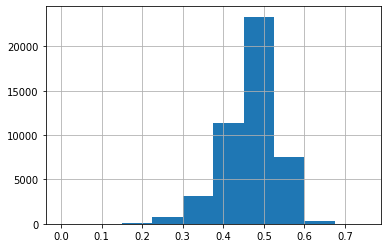

In [34]:
# Plot the histgraom of stopwords
df.pct_stopwords.hist() # distribution of stopwords

In [35]:
# select reviews with 0 percent stopwords
# use df.loc[condition, 'reviewtext'] with the appropriate condition
df.loc[df.pct_stopwords==.0, 'reviewtext']

2018     Good service csdgh jhggrr hfdsew bczss hgdsssa...
8014     良かったところ： 高級感あふれるホテル内装の装飾が素敵でした。 とにかく何でも高価なので、高...
38546    good value, nice pool & seafood buffet...........
42284    Great stay. !!!!!!!!!!!!Great stay. !!!!!!!!!!...
Name: reviewtext, dtype: object

**Answer this**
There should only be 1 non-English review above. What is its index number?

1. **8014**

In [36]:
# remove the non-english review
# use df = df.loc[df.index != the non-english review index].reset_index()

df = df.loc[df.index!=8014].reset_index() # fill this in

In [37]:
# compute the polarity and subjectiity using the TextBlob library for every review
# create 2 new columns for these values: 'polarity' and 'subjectivity'

df['polarity'] = df['reviewtext'].apply(lambda x: TextBlob(x).sentiment.polarity) # calculate polarity and subjectivity in one shot
df['subjectivity'] = df['reviewtext'].apply(lambda x: TextBlob(x).sentiment.subjectivity) # calculate polarity and subjectivity in one shot

# this may take a few minutes to run

In [38]:
# compute the correlation matrix betwee reviewrating, polarity, and subjectivity
df[['reviewrating', 'polarity', 'subjectivity']].corr()

,reviewrating,polarity,subjectivity
reviewrating,1.000000,0.591453,0.237701
polarity,0.591453,1.000000,0.440534
subjectivity,0.237701,0.440534,1.000000


**Answer this**
What does the correlation between review rating and subjectivity tell you about the information contained in the review text vs. the rating? Is review rating an adequate summary statistic about the review text's polarity?

1. **The correlation between review rating and subjectivity shows a weak positive linear relationship between review rating and subjectivity. Considering the weak correlation, the review rating does not well reflect the subjectivity of the review. The corelation between review rating and the polarity is a modarately strong positive correlation. Therefore, it can be assumed that review rating an adequate summary statistic about the review text's polarity**

What about the correlation between polarity and subjectivity, what can you conclude about reviewers' emotionality (subjectivity) as a function of polarity? (Review what correlation measures and then apply that logic to these 2 sentiment variables) 

1. **The correlation suggests a moderate linear relationship between polarity and subjectivity. Therefore on average, it can be assumed that a reviewers' emotionality is directly proportional to the reviews polarity.**

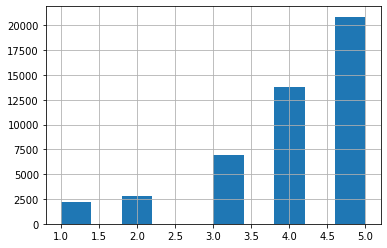

In [39]:
# plot the histogram of review rating
df.reviewrating.hist()

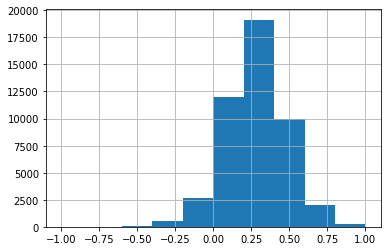

In [40]:
# plot the histogram of polarity
df.polarity.hist()

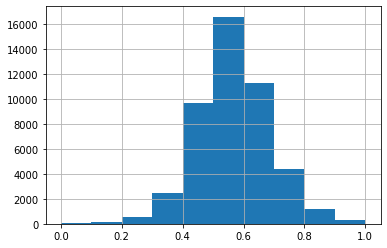

In [41]:
# plot the histogram of subjectivity
df.subjectivity.hist()

**Answer this**
1. Are most reviews positive or negative?
    1. **Most of the reviews are positive. The high review ratings dominate in frequency as can be shown by the histogram plot of the review ratings**
1. Are most reviews subjective or objective? (subjective >.5)
    1. **most reviews are subjective. About 71.98 of the reviews have a subjectivity greater than 0.5**

In [42]:
# compute the average polarity and review rating by travel_category
# use a groupby statement 
df.groupby('travel_category')['polarity', 'reviewrating'].mean().sort_values(by = 'polarity')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,polarity,reviewrating
travel_category,,
business,0.262430,3.900085
solo,0.279972,4.080357
friends,0.282550,3.988150
family,0.285480,4.054054
couple,0.286445,4.119497


**Answer this**

Are the ranks of categories by review rating the same as the ranks by polarity? If not, posit some potential explanations.

**Not fully. Even though ranking by polarity or the review rating both ranks the first and the last category correctly, there is a difference in how the two methods ranks the other three categories i.e. solo, friends, and family.**

# Preprocessing for topic analysis (1)

Before we can do topic analysis, we need to pre-process the texts.

1. Lemmatization
1. Phrase detection

These steps may take some time.


## Lemmatization

**Answer this** 

1. What is the purpose of lemmatization? 
    1. **To simplify the text while still maintaining the topical meaning of the text. This can be achieved by converting plurals into singulars and conjugated verbs into infinitives.**
1. How does lemmatization help simplify the topic modeling problem? 
    1. **By converting plurals into singulars and conjugated verbs into infinitives.**
1. Give at least 3 examples of how some words may be lemmatized.
    1. Changing walking to walk
    1. converting plural words to singular ex. cars to car
    1. changing pronouns to -PRON- ex. I is changed to -PRON-

In [43]:
# Create an nlp subfolder if it doesn't yet exist
# call this subfolder nlppath
nlppath = fpath + 'nlppath/'
try:
    os.listdir(nlppath)
except:
    os.mkdir(nlppath)

In [44]:
# remove any return or new line characters from the review texts
# replace reviewtext column with the cleaned up review texts
df['reviewtext'] = df.reviewtext.str.replace('\r', '').str.replace('\n', '')

In [45]:
# create a list of review texts from column of review texts
texts = list(df.reviewtext)

# write the raw texts to disk where 1 row = 1 review
with open(nlppath + 'rawtexts.txt', 'w', encoding = 'utf-8') as f:
    f.write('\n'.join(texts))

In [46]:
# import stopwords again
sw = stopwords.words('english')


In [47]:
# use the spacy library, create the variable nlp which is the english language model
# i.e. nlp = spacy.load(...)
nlp = spacy.load('en_core_web_sm')

In [48]:
# use the write_parsed_sentence_corpus function to lemmatize the reviews
# do not stop this cell, if you do, you must reload the nlp function in previous cell before executing again

readfile = nlppath + 'rawtexts.txt' # use the location of the raw review texts
writefile = nlppath + 'review_sentences.txt' # specify a location for the lemmatized review sentences

t0 = time.time() # time your code
write_parsed_sentence_corpus(readfile, writefile, nlp, batch_size = 1000, n_threads = 1, sw=sw, exclusions = ['-PRON-'], encode = 'utf-8')
td = (time.time()-t0)/60

Success


In [49]:
# print out how long it took to run
print('Took {:.2f} minutes'.format(td)) 

Took 7.18 minutes


**Answer these**
1. Explain the logic behind how phrase detection (aka phrase modeling) works.
    1. **It identifies words that are commonly used together and identifies it as a phrase. This way it can create a meaning out of the text by identifying phrases in the text** 
1. If phrase modeling is run twice, what is the maximum length of a detected phrase?
    1. **4**

In [50]:
# run phrase detection
t0 = time.time() # time your code
# ngrams = phrase_detection(....)
ngrams = phrase_detection(nlppath + 'review_sentences.txt', nlppath)  # runs 2 iterations by default
td = (time.time()-t0)/60 #calculate time difference

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [51]:
print('Took {:.2f} minutes'.format(td))

Took 0.79 minutes


In [52]:
# list the nlppath directory
os.listdir(nlppath)

['rawtexts.txt',
 'review_sentences.txt',
 'phrase_model_1.phrasemodel',
 'sent_gram_1.txt',
 'phrase_model_2.phrasemodel',
 'sent_gram_2.txt']

In [53]:
# use line_doc to preview a few sentences from sent_gram_2
# construct line generator here, call it "lines":
lines = line_doc(nlppath + 'sent_gram_2.txt')

In [54]:
# preview sentences here, run this cell a few times, make sure you see some phrases
# phrases are denoted by "_" combining 2 words
next(lines) 

'excellent property\n'

In [55]:
# use phrase_prediction function to produce a file that is lemmatized and phrased and 1 line = 1 **review**
# each review will be lemmatized and phrase-detected
nlp = spacy.load('en_core_web_sm')

t0 = time.time()
phrase_prediction(nlppath + 'rawtexts.txt', nlppath + 'parsed_reviews.txt',nlp, ngrams, sw = sw, exclusions = ['-PRON-'], batch_size = 500, n_threads = 2, encode = 'utf-8')
td = (time.time()-t0)/60 #calculate time difference

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [56]:
print('Took {:.2f} minutes'.format(td))

Took 7.98 minutes


In [57]:
# let's take a look at what we did
# construct line generator here, call it "lines", to preview the output of the 
# phrase prediction step

lines = line_doc(nlppath + 'sent_gram_2.txt') # fill this in here

In [58]:
# look at a few reviews
next(lines)

'excellent property\n'

In [59]:
# read in reviews file as list of reviews
with open(nlppath + 'parsed_reviews.txt', 'r', encoding = 'utf-8') as f:
    reviews = f.readlines()

In [60]:
# make sure list of parsed reviews is the same length as the dataframe
len(reviews), len(df)

(46643, 46643)

In [61]:
# set column, parsed, to equal list of parsed reviews
df['parsed'] = reviews

In [62]:
# Save the dataframe
if 1==1:
    df.to_csv(nlppath + 'TripAdvisor_parsed.csv', encoding = 'utf-8')
else:
    df = pd.read_csv(nlppath + 'TripAdvisor_parsed.csv', index_col = 0, encoding = 'utf-8')

# TFIDF Model (3 points)

**Answer these**
1. What does TF-IDF stand for? 
    1. **Term Frequency x Inverse Document Frequency**
1. What are the 2 fundamental ways of counting word frequencies that is embedded into the logic of TF-IDF? In your own words, what is the logical relationship between each type of word frequency and the word's importance in representing a document.
    1. **First one**
        1. **The first to identify and the words that are common in the reviews**
    1. **Second one**
        1. **the second logic is about identifying words that appear only a few times in the documents. The words that are much less frequent.**

## Construct dictionary and corpus

In [63]:
# list of documents as list of words where 1 document = all reviews for a business
reviews = list(df.parsed.str.split()) # construct list of list of words (outer list is per review)

# compute dictionary
dictionary = corpora.Dictionary(reviews)

# look at number of words in vocabulary
print(len(dictionary))

45537


**Answer these**

1. Why might you want to filter out words that appear in too few documents?
    1. **Because they appear only in a few documents, they can not help the computer understand their meaning in different context to help the computer learn their meaning**
1. Why might you want to filter out words that appear in too many documents?
    1. **Because they exist in so many reviews, they are of little use in determining the distinction in the topical meaning of the reviews.**


In [64]:
# filter out too frequent or too infrequent words
dictionary.filter_extremes(no_below=10, no_above=.10)
# no_below is the lower qualifying limit of documents in which a word appears
# no_above is the upper qualifying proportional limit in which a word appears
print(len(dictionary))


11402


In [65]:
# construct a corpus which is like list of bag of words
# where each bag of words is a dictionary of word ID's mapped to word count in document
corpus = [dictionary.doc2bow(r) for r in reviews]

## Create the TF-IDF model, look at keywords for a few reviews

In [66]:
tfidf = tfidfmodel.TfidfModel(corpus, dictionary = dictionary) # compute the tfidf model

In [67]:
def tfidf_keywords(txt, tfidf, dictionary, topn = 5):
    """
    Takes in a parsed string, txt
    a tfidf mode, tfidf
    a gensim dictionary, dictionary,
    and parameter topn that defines the number of top keywords to return
    outputs topk, a list of tuples (keyword, keyword tfidf score)
    """
    topk = sorted([(dictionary[t],f) for t,f in tfidf[dictionary.doc2bow(txt)]], key=lambda x: -x[-1])[:topn]
    return topk

In [68]:
# create column of top5 words
df['top5_tfidf'] = df.parsed.str.split().apply(lambda x: tfidf_keywords(x, tfidf, dictionary, topn = 5))

In [69]:
# randomly sample a review (run a few times)
r = df.sample(1) # sample a single row, r
txt = r.reviewtext.iloc[0] # extract review text
rating = r.reviewrating.iloc[0]
hotel = r.v_name.iloc[0]
keywords = r.top5_tfidf.iloc[0] # extract TFIDF keywords 
print('{} star review'.format(rating), hotel)
print(txt)
print(keywords)

5 star review Vdara Hotel & Spa
Vdara has a sexy edge! Just off the strip connected to the Belagio. Great value for really good location! The room was trendy and very spacious! Love love love the big soaking tub. We had a room on the 46th floor overlooking the fountains. Couldn't ask for a better view! Concierge was great! They helped us navigate the busy strip and gave some great recommendations on food. The cafe in the lobby had THE BEST french toast on earth! We ate there every day!
[('46th_floor', 0.32990141535803524), ('french_toast', 0.2857176179851801), ('soaking_tub', 0.27776662081773784), ('overlook_fountain', 0.2670492446886166), ('sexy', 0.25928367136947605)]


**Answer this**

Try to sample a few reviews and their respective keywords, did they make sense? Explain.

1. **Yes, they make sense. The ratings reflects the reviews. An example is given below where the review is of a five star rating and it clearly reflects on the subjectivity of the review.**

Below is a captured example of a review

5 star review Wynn Las Vegas

Many hotels in Vegas offer many attractions and activities, besides casinos. The Wynn is just another experience in itself with extremely friendly staff, very helpful and informative. The social atmosphere is unique and unforgettable, non-comparable with other higher-end hotels around. At the Wynn, the feeling is of staying in a very nice resort, not in Las Vegas.

[('unforgettable', 0.3324441005377115), ('social', 0.3224438281091757), ('wynn', 0.3080663877000612), ('informative', 0.2968189827000601), ('comparable', 0.2661181791586344)]

# Run LDA Model, explore topics (4 points)

**Answer this**

In your own words, 1) describe LDA model 2) what advantages does it have over TF-IDF?

1. **A Latent Dirichlet Allocation (LDA) model is a topic modelling technique where each document is represented as a distribution over topics**
2. **LDA enables the identification of similar documents or similar reviews and can be used to classify or identify similar objects of interest like hotels etc.**

In [70]:
from gensim.models.ldamulticore import LdaMulticore # import lda function
run = True
if run:
    t0 = time.time()
    perplexity = list()
    # define a training and testing set
    corpus_train, corpus_test = train_test_split(corpus, test_size = .05)
    for numtopics in range(20, 201, 20): # loop through 20,40,...200 topics
        lda = LdaMulticore(corpus_train, id2word=dictionary, num_topics=numtopics)
        lda.save(nlppath+'lda{}.lda'.format(numtopics)) # save the model so we can load it up again later w/o running the model
        p = lda.log_perplexity(corpus_test) # compute the perplexity on testing set
        # save numtopics,p to the perplexity list 
        perplexity.append([numtopics, p])
        # print out number of topics
        print(numtopics)
    perplexity = pd.DataFrame(perplexity, columns = ['ntopics', 'perplexity'])
    td = time.time()-t0
    print('Took {:.2f} minutes'.format(td/60))

20
40
60
80


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


100
120
140
160
180
200
Took 17.02 minutes


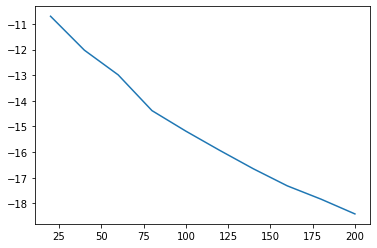

In [71]:
if run:
    plt.plot(perplexity.ntopics, perplexity.perplexity)

**Answer Question**

How many topics appear to minimize perplexity? **The more the topics the less the perplexity. In this case, looking at the plot above; 200 topics minimizes the perplexity.**

In [72]:
# Load lda best model
ntopics = 200
lda = LdaMulticore.load(nlppath + 'lda{}.lda'.format(ntopics))
lda.minimum_probability = 0.

In [73]:
# view all topics
lda.show_topics(ntopics)

[(0,
  '0.053*"smoke" + 0.046*"caesar_\'s" + 0.045*"luxury" + 0.034*"mgm_grand" + 0.021*"hate" + 0.021*"beat" + 0.018*"smell" + 0.016*"generally" + 0.015*"thrill" + 0.014*"attend_conference"'),
 (1,
  '0.048*"mandalay" + 0.046*"signature" + 0.034*"purchase" + 0.026*"tower" + 0.018*"cabana" + 0.017*"balcony" + 0.014*"two" + 0.014*"suite" + 0.013*"vip" + 0.013*"access"'),
 (2,
  '0.023*"hardly" + 0.018*"winner" + 0.017*"cockroach" + 0.016*"heavy" + 0.012*"ready" + 0.012*"horrendous" + 0.011*"mirror" + 0.011*"another" + 0.010*"shirt" + 0.009*"large"'),
 (3,
  '0.038*"2015" + 0.033*"center_strip" + 0.030*"bellagio_fountain" + 0.027*"$_5" + 0.025*"business_trip" + 0.021*"$_100" + 0.020*"joint" + 0.020*"surround" + 0.016*"constant" + 0.015*"tear"'),
 (4,
  '0.053*"classy" + 0.039*"resort" + 0.030*"walk_distance" + 0.023*"smoke_free" + 0.021*"dining_option" + 0.020*"incredible" + 0.019*"elegant" + 0.019*"nightlife" + 0.016*"shopping" + 0.016*"caesars_palace"'),
 (5,
  '0.025*"neat" + 0.020*"h

**Answer this**

Pick 3 topics that you can label. Explain your label choice. 

1. Amazed - this shows positivity and has relatively high ratings
2. Play - the topic has a high rating
3. Fresh - Also show positivity and also highly rated as top topic

**Answer here**


**Explore topics**

In [74]:
# predict back the topic weights on each review
df['topic_probs'] = df.parsed.str.split().apply(lambda x: dict(lda[dictionary.doc2bow(x)]))


In [75]:
# create top_k  columns for k = 0,...,ntopics
# where top_k is the probability of each review representing topic k
for t in range(ntopics):
    df['top_{}'.format(t)] = df.topic_probs.apply(lambda x: x.get(t))


In [76]:
# create a variable that contains the list of top_k column names
topiccols = ['top_{}'.format(t) for t in range(ntopics)]

### Topics by travel category

In [77]:
# for each travel category, compute the average of all the topiccols 
# use .T at the end to transpose (i.e. rotate 90 deg) the dataframe
topicmeans = df.groupby('travel_category')[topiccols].mean().T

In [78]:
# preview the topicmeans dataframe
topicmeans.head()

travel_category,business,couple,family,friends,solo
top_0,0.009131,0.006785,0.005452,0.006917,0.006364
top_1,0.005294,0.005137,0.004860,0.004164,0.004032
top_2,0.003398,0.003250,0.003070,0.003055,0.003751
top_3,0.007102,0.004721,0.004694,0.005279,0.005154
top_4,0.009835,0.008314,0.007859,0.009012,0.008530


In [79]:
# use sort_values on topicmeans to find the common topic among solo travelers
# use ascending = False option in sort_values to sort from largest to smallest
topicmeans.sort_values(by = 'solo', ascending = False)

travel_category,business,couple,family,friends,solo
top_49,0.009212,0.012204,0.012011,0.016798,0.020672
top_181,0.025418,0.022602,0.023210,0.022643,0.020659
top_59,0.008553,0.008380,0.009268,0.010151,0.011986
top_72,0.006102,0.008322,0.011747,0.010572,0.011009
top_196,0.009100,0.011143,0.012030,0.012764,0.010467
...,...,...,...,...,...
top_96,0.003080,0.002552,0.003219,0.002908,0.002273
top_185,0.002553,0.002177,0.002007,0.001832,0.002204
top_184,0.002506,0.002621,0.002554,0.002207,0.002165
top_81,0.002178,0.001986,0.002138,0.002441,0.002086


**Answer this**

What is the topic ID for solo travelers' most likely review topic? **49**

In [81]:
# take a look at the top solo traveler topic
top_solo = 49 # use the most common solo traveler topic ID here
pd.DataFrame(lda.show_topic(top_solo))

,0,1
0,play,0.117517
1,table,0.079434
2,table_game,0.036213
3,player,0.024147
4,dealer,0.023162
5,machine,0.020366
6,fun,0.019499
7,game,0.017551
8,slot,0.014896
9,friendly,0.014587


In [82]:
# look at the most common topic for business travelers
topicmeans.sort_values(by = 'business', ascending = False)

travel_category,business,couple,family,friends,solo
top_181,0.025418,0.022602,0.023210,0.022643,0.020659
top_80,0.013155,0.012185,0.009510,0.008966,0.008460
top_20,0.012350,0.005140,0.005951,0.004860,0.006404
top_123,0.010313,0.004943,0.005892,0.004925,0.005306
top_56,0.009965,0.008484,0.009335,0.009353,0.008650
...,...,...,...,...,...
top_115,0.002223,0.002515,0.002316,0.001987,0.002798
top_81,0.002178,0.001986,0.002138,0.002441,0.002086
top_13,0.002145,0.002787,0.002332,0.002587,0.002832
top_29,0.002051,0.002157,0.002096,0.002273,0.002514


In [83]:
# preview the most common topic for business travelers
top_bus = 181
pd.DataFrame(lda.show_topic(top_bus))

,0,1
0,tell,0.042469
1,call,0.028085
2,ask,0.022619
3,give,0.017396
4,charge,0.016986
5,manager,0.011458
6,leave,0.010900
7,back,0.010603
8,pay,0.010256
9,front_desk,0.010124


In [84]:
# look at the most common topic for couples
topicmeans.sort_values(by = 'couple', ascending = False)

travel_category,business,couple,family,friends,solo
top_181,0.025418,0.022602,0.023210,0.022643,0.020659
top_49,0.009212,0.012204,0.012011,0.016798,0.020672
top_80,0.013155,0.012185,0.009510,0.008966,0.008460
top_196,0.009100,0.011143,0.012030,0.012764,0.010467
top_161,0.007380,0.010299,0.008159,0.007637,0.006248
...,...,...,...,...,...
top_60,0.002648,0.002257,0.002356,0.002682,0.002353
top_45,0.002521,0.002206,0.002671,0.002482,0.002391
top_185,0.002553,0.002177,0.002007,0.001832,0.002204
top_29,0.002051,0.002157,0.002096,0.002273,0.002514


In [85]:
# preview the most common topic for business travelers
top_couple = 181
pd.DataFrame(lda.show_topic(top_couple))

,0,1
0,tell,0.042469
1,call,0.028085
2,ask,0.022619
3,give,0.017396
4,charge,0.016986
5,manager,0.011458
6,leave,0.010900
7,back,0.010603
8,pay,0.010256
9,front_desk,0.010124


### Topics by rating for 1 hotel

In [86]:
# print out unique hotels
df.v_name.unique()

array(['Encore At Wynn Las Vegas', 'New York - New York Hotel and Casino',
       "Bally's Las Vegas", 'Venetian Resort Hotel Casino',
       'Rio All-Suite Hotel & Casino', 'Wynn Las Vegas',
       'MGM Grand Hotel and Casino',
       'Tropicana Las Vegas - A DoubleTree by Hilton Hotel',
       'Excalibur Hotel & Casino', 'Monte Carlo Resort & Casino',
       'The LINQ Hotel & Casino', 'Hard Rock Hotel and Casino',
       'Paris Las Vegas', 'The Mirage Hotel & Casino',
       'Trump International Hotel Las Vegas', 'Plaza Hotel & Casino',
       'Caesars Palace', 'Luxor Las Vegas', 'Signature at MGM',
       'Planet Hollywood Resort & Casino', 'Vdara Hotel & Spa',
       'Golden Nugget Hotel', 'Treasure Island - TI Hotel & Casino',
       'Stratosphere Hotel, Casino and Tower',
       'Mandalay Bay Resort & Casino',
       'The Cosmopolitan of Las Vegas, Autograph Collection',
       'SLS Las Vegas Hotel & Casino', 'Bellagio Las Vegas',
       'Circus Circus Hotel & Casino Las Vegas',


In [87]:
# pick out a hotel to analyze in detail
hotel = 'Wynn Las Vegas'
df_h = df.loc[df.v_name==hotel].reset_index(drop = True)

In [88]:
# compute the average topic probability for each rating level
topicmeans = df_h.groupby('reviewrating')[topiccols].mean().T

In [89]:
# look at top topics for 1 star ratings
topicmeans.sort_values(by = 1, ascending = False)

reviewrating,1,2,3,4,5
top_181,0.175073,0.095533,0.055955,0.027615,0.007667
top_139,0.052034,0.010271,0.009162,0.005834,0.009914
top_125,0.033236,0.021879,0.012535,0.012060,0.005633
top_106,0.031935,0.045108,0.054055,0.052010,0.093271
top_105,0.021065,0.005543,0.013361,0.004229,0.003182
...,...,...,...,...,...
top_76,0.000140,0.002157,0.001062,0.004981,0.004172
top_135,0.000140,0.004482,0.002035,0.004525,0.003432
top_97,0.000140,0.001372,0.002851,0.001367,0.005332
top_1,0.000140,0.000147,0.006204,0.004681,0.001410


In [90]:
# look at the highest rated topic for 1 star ratings
lda.show_topic(181) 

[('tell', 0.042469166),
 ('call', 0.02808484),
 ('ask', 0.022618754),
 ('give', 0.017395891),
 ('charge', 0.016986221),
 ('manager', 0.011457581),
 ('leave', 0.010900232),
 ('back', 0.010602543),
 ('pay', 0.010256248),
 ('front_desk', 0.010124119)]

In [91]:
# look at top topics for 5 star ratings
topicmeans.sort_values(by = 5, ascending = False)


reviewrating,1,2,3,4,5
top_106,0.031935,0.045108,0.054055,0.052010,0.093271
top_4,0.001573,0.010337,0.005148,0.010848,0.019060
top_57,0.002031,0.009216,0.003215,0.015654,0.014389
top_161,0.001620,0.003207,0.006892,0.007882,0.012685
top_80,0.001956,0.012160,0.010543,0.005412,0.011204
...,...,...,...,...,...
top_1,0.000140,0.000147,0.006204,0.004681,0.001410
top_78,0.008410,0.002029,0.000866,0.000919,0.001360
top_14,0.002528,0.002940,0.001209,0.002296,0.001358
top_13,0.003216,0.001812,0.000946,0.000907,0.001144


In [92]:
# look at the highest rated topic for 5 star ratings
# that are not in the top 5 for 1 star ratings
lda.show_topic(106)


[('wynn', 0.185391),
 ('encore', 0.038620487),
 ('fitness_center', 0.018038912),
 ('open_door', 0.015027859),
 ('gym', 0.012879832),
 ('wynn_encore', 0.012396172),
 ('power', 0.011619463),
 ('equipment', 0.009314022),
 ('spa', 0.009155681),
 ('near_elevator', 0.008470626)]

**Answer Question**

Any intuition behind the distinctive 5 star topic and the top 1 star topic? Explain.

1. **The LDA is able to classify similar reviews and topic making it distinctive when compared to topics in 1 star ratings**

# Create wordcloud from LDA (+2 Bonus)



## Example for creating 1 wordcloud

In [93]:
# to get the topic weights for topic k:
k = 0
# topn = number of top words to use
topicwts = dict(lda.show_topic(k, topn = 100))

In [94]:
from wordcloud import WordCloud
wc = WordCloud(width = 1920, height = 1080, background_color = 'white').fit_words(topicwts) # specify w/h for HD figure

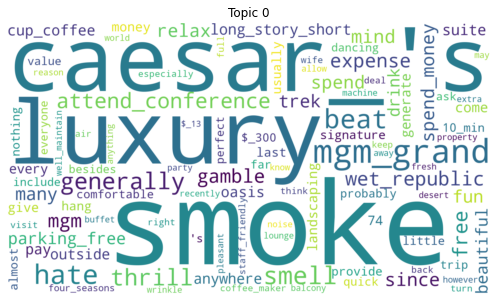

In [95]:
# plot wc
plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation='bilinear')
plt.title('Topic {}'.format(k))
plt.axis('off')
plt.show()

## Challenge problem (for the bonus): 
Use only the data from your chosen hotel, i.e. df_h.

For positive and negative reviews, where positive is 4-5 stars and negative is 1-3 stars, create a wordcloud for any of the top 5 topics for that category of ratings that are not in the top 5 of the other category. For instance, if topic 88 is one of the top 5 topics for negative reviews and **not** one of the top 5 topics for positive reviews, then create a wordcloud for it. Make sure that the title of the wordcloud image reflects the review type (positive/negative) and the topic number: e.g., 'Positive review topic: 88'.

*Use what you have learned throughout the semester and the internet to figure out how to do this without any hard-coded results, especially with respect to selecting the topics to visualize. For example: use code to write a generic solution such that you do not have to manually select the topics used for word cloud. If you had to re-run the code where top 5 topics is now top 3 topics, you should only have to change the 5 to 3 once in the code.



In [1]:
# solution below, feel free to add multiple additional cells
##using ratings 4 get the topic ID
topicmeans.sort_values(by = 5, ascending = False).head(2)

NameError: ignored

In [ ]:
topicmeans.sort_values(by = 4, ascending = False).head(2)

In [ ]:
lda.show_topic(101) 

In [ ]:
pos = lda.show_topic(35) 

In [ ]:
print(topicmeans.sort_values(by = 1, ascending = False).head(2))
print(topicmeans.sort_values(by = 2, ascending = False).head(2))
print(topicmeans.sort_values(by = 3, ascending = False).head(2))